#### Import Libraries

In [28]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

#### Load Dataset

In [30]:
df = pd.read_csv(r"C:\Users\sbane\Desktop\Machine Learning\ML Project\Pet photos\train.csv")

# Extract metadata features and target variable
metadata_features = df.iloc[:, 1:-1].values  # Exclude ID and target column
pawpularity = df["Pawpularity"].values  # Target variable

# Normalize metadata features
scaler = StandardScaler()
metadata_features = scaler.fit_transform(metadata_features)

#### Train-Test Split

In [32]:
train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Split metadata using the indices
X_train_meta = metadata_features[train_idx]
X_val_meta = metadata_features[val_idx]
y_train = pawpularity[train_idx]
y_val = pawpularity[val_idx]

# Extract image IDs using the same split indices
train_image_ids = df.iloc[train_idx, 0].values  # Image IDs for training
val_image_ids = df.iloc[val_idx, 0].values  # Image IDs for validation

#### Load and Preprocess Images

In [34]:
IMG_SIZE = 224  # Image input size
IMG_PATH = r"C:\Users\sbane\Desktop\Machine Learning\ML Project\Pet photos\train"  
# Function to load and preprocess images
def load_images(image_ids, img_dir, img_size):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(img_dir, img_id + ".jpg")  # Modify extension if needed
        if os.path.exists(img_path):  # Check if file exists
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            img = img / 255.0  # Normalize pixels
            images.append(img)
        else:
            print(f"Warning: Image {img_id}.jpg not found in {img_dir}")  # Debugging
            images.append(np.zeros((img_size, img_size, 3)))  # Placeholder for missing images
    return np.array(images)

# Load images for training and validation using correct indices
X_train_img = load_images(train_image_ids, IMG_PATH, IMG_SIZE)
X_val_img = load_images(val_image_ids, IMG_PATH, IMG_SIZE)

#### Verify Shapes to Prevent Errors

In [36]:
print(f"X_train_img shape: {X_train_img.shape}")  # Should match X_train_meta
print(f"X_train_meta shape: {X_train_meta.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_img shape: {X_val_img.shape}")  # Should match X_val_meta
print(f"X_val_meta shape: {X_val_meta.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_img shape: (7929, 224, 224, 3)
X_train_meta shape: (7929, 12)
y_train shape: (7929,)
X_val_img shape: (1983, 224, 224, 3)
X_val_meta shape: (1983, 12)
y_val shape: (1983,)


#### Define the CNN Model

In [44]:
# Define RMSE as a custom metric
def set_seed(seed=52):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow
 
    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


def rmse(y_true, y_pred):
    y_true = K.cast(y_true, dtype="float32")  # Convert y_true to float32
    y_pred = K.cast(y_pred, dtype="float32")  # Convert y_pred to float32
    return K.sqrt(K.mean(K.square(y_true - y_pred)))  # Compute RMSE

def build_model():
    set_seed(52)

    # Image input & feature extractor (CNN)
    image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Image_Input")
    base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet")

    # Freeze all layers first
    base_model.trainable = False  

    # Unfreeze the last 15 layers
    for layer in base_model.layers[-15:]:
        layer.trainable = True  

    x = Flatten()(base_model.output)

    # Tabular metadata input
    metadata_input = Input(shape=(X_train_meta.shape[1],), name="Metadata_Input")
    y = Dense(32, activation="tanh")(metadata_input)
    y = Dropout(0.2)(y)

    # Concatenation of image and metadata features
    combined = Concatenate()([x, y])
    z = Dense(64, activation="tanh")(combined)
    z = Dropout(0.2)(z)
    z = Dense(128, activation="tanh")(z)
    z = Dense(1, activation="linear")(z)  # Regression output

    # Define model
    model = Model(inputs=[image_input, metadata_input], outputs=z)
    
    # Compile model using RMSE as a metric
    model.compile(optimizer=Adam(learning_rate=0.0003), loss="mse", metrics=[rmse])
    
    return model

# Initialize model
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ Image_Input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 224, 224, 3)       │               7 │ rescaling_4[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 8,074,628 (30.80 MB)

 Trainable params: 4,933,265 (18.82 MB)

 Non-trainable params: 3,141,363 (11.98 MB)

#### Train the Model

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop if validation loss stops improving
    patience=2,          # Wait for 2 epochs without improvement
    restore_best_weights=True  # Restore the best model
)

# Train the model with early stopping
history = model.fit(
    [X_train_img, X_train_meta], y_train,
    validation_data=([X_val_img, X_val_meta], y_val),
    epochs=10, 
    batch_size=32,
    callbacks=[early_stopping]  
)


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: 1135.6516 - rmse: 33.1720 - val_loss: 687.8111 - val_rmse: 25.7850
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 245s 988ms/step - loss: 604.1839 - rmse: 24.1255 - val_loss: 517.9728 - val_rmse: 22.3151
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - loss: 468.4659 - rmse: 21.2031 - val_loss: 460.3863 - val_rmse: 21.0688
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 248s 1000ms/step - loss: 425.0481 - rmse: 20.2241 - val_loss: 445.2968 - val_rmse: 20.7636
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 414.4022 - rmse: 20.0081 - val_loss: 442.4446 - val_rmse: 20.7217
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 412.6205 - rmse: 19.9854 - val_loss: 442.0691 - val_rmse: 20.7231
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 245s 987ms/step - loss: 412.5182 - rmse: 19.9897 - val_loss: 442.0370 - val_rmse: 20.7257
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 242s 976ms/step - loss: 412.4515 - rmse: 19.9923 - val_loss:

#### Evaluate the Model

In [48]:
val_loss, val_rmse = model.evaluate([X_val_img, X_val_meta], y_val)
print(f"Validation RMSE: {val_rmse:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 621ms/step - loss: 434.8739 - rmse: 20.5793
Validation RMSE: 20.7266


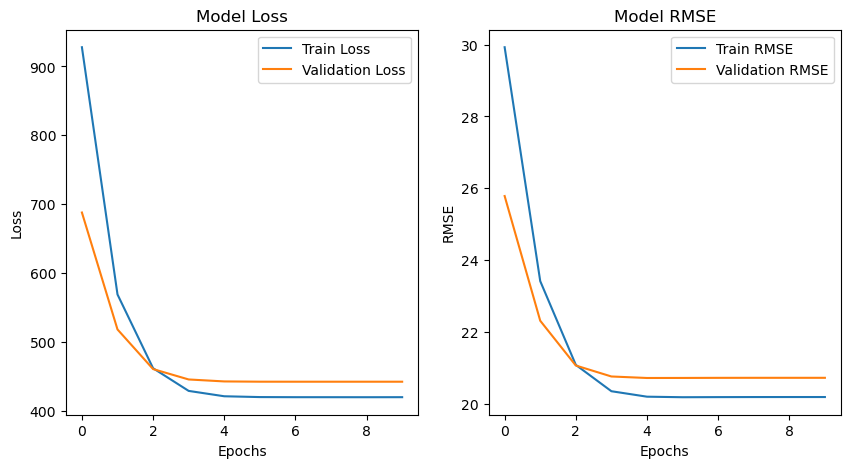

In [50]:
# Step 9: Loss and RMSE graphs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()